In [1]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_moons

In [2]:
class Flowmodel(nn.Module):
    def __init__(self, dim = 2, hidden_dim = 64):
        super(Flowmodel, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.layers = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim), # +1 for time dimension 
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        ''' 
        Predicts the velocity at x_t at time t
        
        Args:
        x_t: tensor of 2 dim positions
        t: tensor of times
        '''
        return(self.layers(torch.cat((x_t, t), dim=-1)))
    
    def sample(self, x: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1,1).expand(x.shape[0], 1)
        t_end = t_end.view(1,1).expand(x.shape[0], 1)
        dt = t_end - t_start
        x_end = x + self.forward(x_t = x, t = t_start) * dt # Use forward Euler step
        return x_end
    
    def sample_mid_euler(self, x: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1,1).expand(x.shape[0], 1)
        t_end = t_end.view(1,1).expand(x.shape[0], 1)
        dt = t_end - t_start
        x_mid = x + self.forward(x_t = x, t = t_start + dt / 2) * dt
        return x_mid
    
    def sample_rk2(self, x: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        # Runge-Kutta 2nd order method
        t_start = t_start.view(1,1).expand(x.shape[0], 1)
        t_end = t_end.view(1,1).expand(x.shape[0], 1)
        dt = t_end - t_start
        return (x + dt * self.forward(x_t = x + self(x_t=x, t=t_start) * (t_end - t_start) / 2,
                                      t=t_start + (t_end - t_start) / 2))


### Training a flow

In [118]:
dataset = 'moons' # can also make_swiss_roll

flow_model = Flowmodel(dim = 2, 
                       hidden_dim = 64)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(flow_model.parameters(), lr=0.01)

n_iters = 10000
for iter in range(n_iters):
    if dataset == 'moons':
        x1 = Tensor(make_moons(n_samples=256, noise=0.05)[0][:, :2])
    if dataset == 'swiss_roll':
        x1 = Tensor(make_swiss_roll(n_samples = 256, noise=0.5)[0][:, [0,2]]) / 5 # Use the swiss role dataset
    x0 = torch.randn_like(x1)  # Random initial points
    t = torch.rand(x0.shape[0], 1)
    
    v_target = x1 - x0
    xt = x0 + v_target * t  # Simulate the target state at time t
    v_pred = flow_model(xt, t)
    
    optimizer.zero_grad()
    loss_value = loss(v_pred, v_target)
    loss_value.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f"Step {iter}, Loss: {loss_value.item()}")


Step 0, Loss: 1.5510708093643188
Step 1000, Loss: 1.1208531856536865
Step 2000, Loss: 0.9560340642929077
Step 3000, Loss: 0.9959648847579956
Step 4000, Loss: 1.054372787475586
Step 5000, Loss: 0.9124968647956848
Step 6000, Loss: 0.963939905166626
Step 7000, Loss: 0.9906200766563416
Step 8000, Loss: 0.9301936626434326
Step 9000, Loss: 0.9744177460670471


Plot the selected noisy dataset

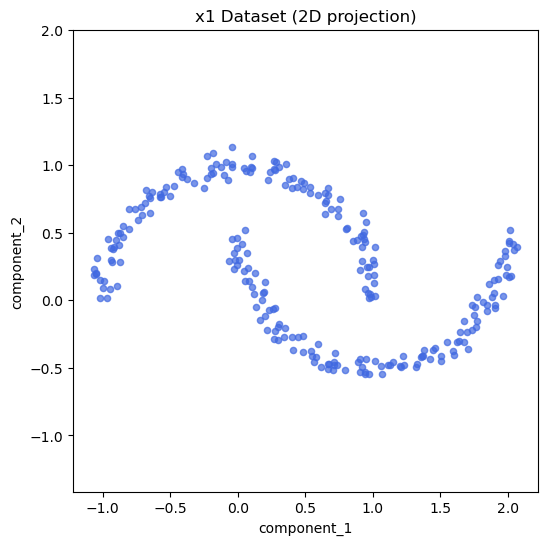

In [119]:
plt.figure(figsize=(6,6))
plt.scatter(x1[:,0], x1[:,1], c='royalblue', s=20, alpha=0.7)
plt.xlabel("component_1")
plt.ylabel("component_2")
plt.title("x1 Dataset (2D projection)")
plt.axis("equal")
plt.show()

### Investigate the variation of the learned time-dependent flow

The following function computes the learned vector field at time $t$, also its average vect. length, std vect. length, as well as divergence / curl.

In [120]:
import torch
import numpy as np

def compute_variation(vft, 
                      xrange, 
                      yrange, 
                      grid_size, 
                      t, 
                      verbose = False):
    """
    Args:
        vft: Flowmodel instance
        xrange, yrange: (min, max)
        grid_size: (nx, ny)
        t: float, time
        verbose: print description

    Return:
        ( vect_t, 
          stat_t = (vectt_len_mean, vectt_len_std), 
          div_t,
          curl_t)
    """
    nx, ny = grid_size
    xs = np.linspace(xrange[0], xrange[1], nx)
    ys = np.linspace(yrange[0], yrange[1], ny)
    X, Y = np.meshgrid(xs, ys, indexing="ij")
    grid_points = np.stack([X, Y], axis=-1).reshape(-1, 2)

    def eval_field(time):
        pts = torch.tensor(grid_points, dtype=torch.float32)
        tt = torch.full((pts.shape[0], 1), time, dtype=torch.float32)
        v = vft(pts, tt).detach().numpy()   # (N,2)
        return v.reshape(nx, ny, 2)

    # 1. vector field at t and t+dt
    V_t   = eval_field(t)

    # --- Part 1: norm statistics ---
    norms_t   = np.linalg.norm(V_t.reshape(-1, 2), axis=1)
    stat_t    = (norms_t.mean(), norms_t.std())

    # --- Part 2: divergence and curl ---
    def finite_diff(V):
        # V shape (nx, ny, 2)
        # component split
        Vx, Vy = V[..., 0], V[..., 1]
        # central differences (ignore boundary -> shape (nx-2, ny-2))
        dVx_dx = (Vx[2:,1:-1] - Vx[:-2,1:-1]) / (xs[2:,None] - xs[:-2,None])
        dVy_dy = (Vy[1:-1,2:] - Vy[1:-1,:-2]) / (ys[None,2:] - ys[None,:-2])
        div = dVx_dx + dVy_dy

        dVy_dx = (Vy[2:,1:-1] - Vy[:-2,1:-1]) / (xs[2:,None] - xs[:-2,None])
        dVx_dy = (Vx[1:-1,2:] - Vx[1:-1,:-2]) / (ys[None,2:] - ys[None,:-2])
        curl = dVy_dx - dVx_dy
        return div, curl

    div_t, curl_t     = finite_diff(V_t)

    if verbose:
        print(f'Time t vec_length mean {stat_t[0]}, std {stat_t[1]}')
        print(f'Time t div mean {div_t.mean()}, std {div_t.std()}')
        print(f'Time t curl mean {curl_t.mean()}, std {curl_t.std()}')

    out = dict(V_t=V_t, 
               stat_t=stat_t, 
               div_t=div_t, 
               curl_t=curl_t)
    return out


## Sample Usage
xrange = (-3,3)
yrange = (-3,3)
grid_size = (100, 100)
t = 0.1

time_slice = compute_variation(flow_model, xrange, yrange, grid_size, t)
print(f'The vectors of flow at time {t} has mean {time_slice["stat_t"][0]}, and std {time_slice["stat_t"][1]}')

The vectors of flow at time 0.1 has mean 2.5204122066497803, and std 1.0461875200271606


The following function produces 2 plots describing respectively

* Mean / std of vector length of the flow over time 
* Total mean Divergence / Curl of the flow over time

In [121]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_flow_over_time(vft, xrange, yrange, grid_size, time_steps=100, verbose=False):
    """
    Args:
        vft: Flowmodel instance
        xrange, yrange: (min, max)
        grid_size: (nx, ny)
        time_steps: number of time samples between 0 and 1
    """
    from tqdm import tqdm  # optional, for progress bar
    
    times = np.linspace(0, 1, time_steps)
    
    mean_lengths = []
    std_lengths  = []
    mean_divs    = []
    mean_curls   = []

    for t in tqdm(times):
        out = compute_variation(vft, xrange, yrange, grid_size, t, verbose=verbose)
        stat_t = out["stat_t"]   # (mean, std)
        div_t  = out["div_t"]
        curl_t = out["curl_t"]

        mean_lengths.append(stat_t[0])
        std_lengths.append(stat_t[1])
        mean_divs.append(div_t.mean())
        mean_curls.append(curl_t.mean())

    # ---- Plot 1: mean length and std length ----
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(times, mean_lengths, label="Mean length")
    plt.plot(times, std_lengths, label="Std length")
    plt.xlabel("Time t")
    plt.ylabel("Vector norm")
    plt.title("Vector length statistics vs time")
    plt.legend()
    
    # ---- Plot 2: mean divergence and mean curl ----
    plt.subplot(1,2,2)
    plt.plot(times, mean_divs, label="Mean divergence")
    plt.plot(times, mean_curls, label="Mean curl")
    plt.xlabel("Time t")
    plt.ylabel("Value")
    plt.title("Divergence and curl vs time")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


100%|██████████| 20/20 [00:00<00:00, 119.29it/s]


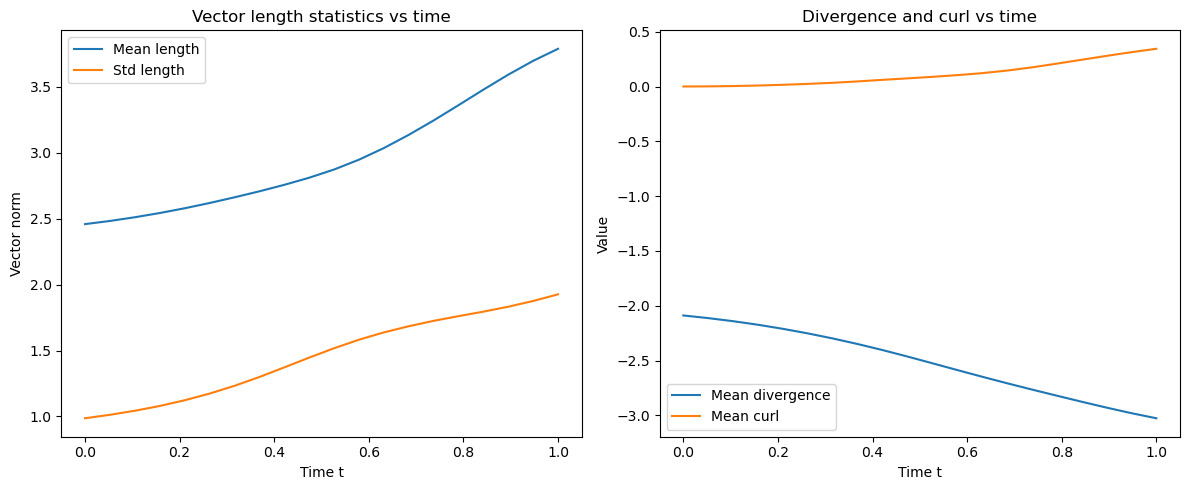

In [122]:
analyze_flow_over_time(flow_model, xrange=(-3,3), yrange=(-3,3), grid_size=(200,200), time_steps=20)

### Sampling Procedure

In the below, we can use
* ```sample_mid_euler``` (midpoint euler method for sampling)
*  ```sample``` (straight forward euler) 
*  ```sample_rk2``` (Runge-Kutta order 2) methods. 

To me it seems the ```sample_mid_euler``` gives the best result.

Below is the reference target distribution $p_1$.

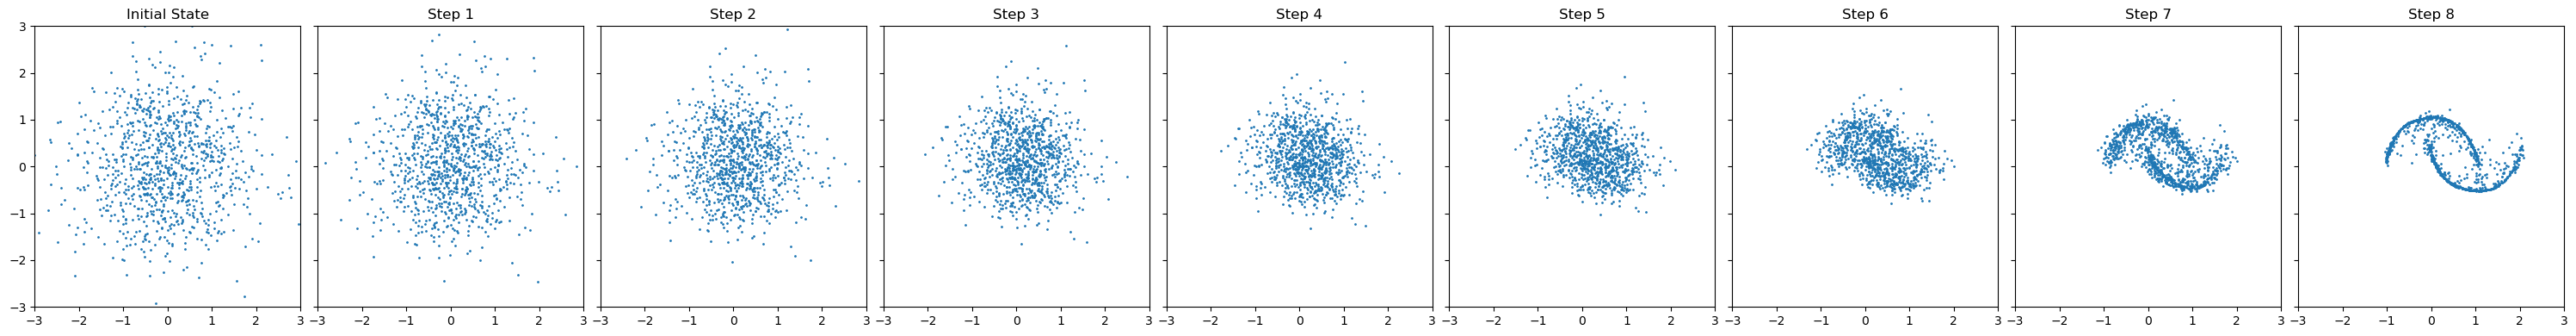

In [124]:
x = torch.randn(1000, 2)  # Sample random points
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex = True, sharey = True)
# The amazing thing is that we can sample at ANY time step, not just the ones we trained on.
time_steps = torch.linspace(0, 1, n_steps + 1).view(-1, 1)

axes[0].scatter(x[:, 0], x[:, 1], s=1)
axes[0].set_title("Initial State")
axes[0].set_xlim(-3,3)
axes[0].set_ylim(-3,3)

for i in range(n_steps):
    x = flow_model.sample_mid_euler(x, time_steps[i], time_steps[i + 1])
    axes[i + 1].scatter(x[:, 0].detach(), x[:, 1].detach(), s=1)
    axes[i + 1].set_title(f"Step {i + 1}")

plt.tight_layout()

In [16]:
from PIL import Image
from os.path import join

def manual_sample(filename, n_samples=256, noise=0.5, scale=5, white_background=True):
    # 1. 读入图像
    path = join('datasets', filename)
    img = Image.open(path).convert("L")   # 转灰度图
    
    # 2. 转成 numpy 数组并二值化
    arr = np.array(img)
    mask = arr < 127 if white_background else arr > 127 # True 表示黑色区域
    
    
    # 3. 找到非零像素坐标
    coords = np.argwhere(mask)   # (row, col)
    if len(coords) == 0:
        raise ValueError("图像没有非零像素，检查输入图片是否是黑白图")
    
    # 4. 随机采样 n_samples 个点
    idx = np.random.choice(len(coords), size=n_samples, replace=True)
    sampled = coords[idx].astype(np.float32)
    
    # 5. 加噪声
    sampled += np.random.randn(*sampled.shape) * noise
    
    # 6. 坐标归一化 & 缩放
    sampled = (sampled - sampled.mean(0)) / sampled.std(0)
    sampled = sampled / scale
    
    # 注意：coords 是 (row, col)，所以要翻转一下变成 (x, y)
    sampled = sampled[:, [1, 0]]
    sampled[:,1] = -sampled[:,1]
    
    # 转 torch tensor
    x = torch.tensor(sampled, dtype=torch.float32)
    return x